# Segment stitching visualization

## Preparation

### Use CuPy to run some matrix operations on GPU
(I found that for example `cp.argwhere` is a lot faster than `np.argwhere` in my case)

In [ ]:
#!pip install cupy-cuda12x
#import cupy as cp

### Imports and authentication

In [ ]:
from google.colab import auth
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches
import cv2 as cv
import pandas as pd
import subprocess
import itertools
from tqdm import tqdm
import os
import numba as nb
import hashlib
plt.style.use("seaborn-v0_8-white")

from google.colab import drive
drive.mount('/content/gdrive')

auth.authenticate_user()

Mounted at /content/gdrive


### Download and prepare metadata file

In [ ]:
!gsutil cp gs://india_field_delineation/metadata/india_airbus_metadata_all.csv /content/metadata.csv
metadata = pd.read_csv("/content/metadata.csv")
metadata[["unknown0", "unknown1", "unknown2", "coord0", "coord1", "coord2"]] = metadata["DLTile_key"].str.split(":", expand=True)
metadata[["coord0", "coord1", "coord2"]] = metadata[["coord0", "coord1", "coord2"]].astype(int)

Copying gs://india_field_delineation/metadata/india_airbus_metadata_all.csv...
\ [1 files][ 11.4 MiB/ 11.4 MiB]                                                
Operation completed over 1 objects/11.4 MiB.                                     


### Extract 16 tiles for testing

In [ ]:
meta_df = metadata.loc[(metadata.image_id == 0) & (metadata.batch == 0) & (metadata.coord0==42) & (metadata.coord1 >= 50) & (metadata.coord1 < 54) & (metadata.coord2 >= 408) & (metadata.coord2 < 412)]
len(meta_df)

16

### Download the images

In [ ]:
"""
for i, row in tqdm(meta_df.iterrows()):
    tile_id = row["tile_id"]
    batch = row["batch"]
    source = "gs://india_field_delineation/predictions/boundary_predictions_4096px_averaged/india_{:02d}/india_{:05d}.png".format(batch, tile_id)
    dest = "/content/gdrive/MyDrive/field_delineation/imgs/boundary/{:02d}_{:05d}.png".format(batch, tile_id)
    os.system(
        f"gsutil cp {source} {dest}"
    )
    source = "gs://india_field_delineation/predictions/watershed_instances_4096px/india_{:02d}/india_{:05d}.npy".format(batch, tile_id)
    dest = "/content/gdrive/MyDrive/field_delineation/imgs/watershed/{:02d}_{:05d}.npy".format(batch, tile_id)
    os.system(
        f"gsutil cp {source} {dest}"
    )
    source = "gs://india_field_delineation/predictions/instance_uncertainty_4096px/india_{:02d}/india_{:05d}.png".format(batch, tile_id)
    dest = "/content/gdrive/MyDrive/field_delineation/imgs/instance_uncertainty/{:02d}_{:05d}.png".format(batch, tile_id)
    os.system(
        f"gsutil cp {source} {dest}"
    )
"""

'\nfor i, row in tqdm(meta_df.iterrows()):\n    tile_id = row["tile_id"]\n    batch = row["batch"]\n    source = "gs://india_field_delineation/predictions/boundary_predictions_4096px_averaged/india_{:02d}/india_{:05d}.png".format(batch, tile_id)\n    dest = "/content/gdrive/MyDrive/field_delineation/imgs/boundary/{:02d}_{:05d}.png".format(batch, tile_id)\n    os.system(\n        f"gsutil cp {source} {dest}"\n    )\n    source = "gs://india_field_delineation/predictions/watershed_instances_4096px/india_{:02d}/india_{:05d}.npy".format(batch, tile_id)\n    dest = "/content/gdrive/MyDrive/field_delineation/imgs/watershed/{:02d}_{:05d}.npy".format(batch, tile_id)\n    os.system(\n        f"gsutil cp {source} {dest}"\n    )\n    source = "gs://india_field_delineation/predictions/instance_uncertainty_4096px/india_{:02d}/india_{:05d}.png".format(batch, tile_id)\n    dest = "/content/gdrive/MyDrive/field_delineation/imgs/instance_uncertainty/{:02d}_{:05d}.png".format(batch, tile_id)\n    os.sys

### Load the images

In [ ]:
boundary_imgs = {}
watershed_imgs = {}
instance_uncertainty_imgs = {}

for i, row in tqdm(meta_df.iterrows()):
    tile_id = row["tile_id"]
    batch = row["batch"]
    img_path = "/content/gdrive/MyDrive/field_delineation/imgs/boundary/{:02d}_{:05d}.png".format(batch, tile_id)
    if os.path.exists(img_path):
        boundary_imgs["{:02d}_{:05d}".format(batch, tile_id)] = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    img_path = "/content/gdrive/MyDrive/field_delineation/imgs/watershed/{:02d}_{:05d}.npy".format(batch, tile_id)
    if os.path.exists(img_path):
        watershed_imgs["{:02d}_{:05d}".format(batch, tile_id)] = np.load(img_path)
    img_path = "/content/gdrive/MyDrive/field_delineation/imgs/instance_uncertainty/{:02d}_{:05d}.png".format(batch, tile_id)
    if os.path.exists(img_path):
        instance_uncertainty_imgs["{:02d}_{:05d}".format(batch, tile_id)] = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

16it [01:02,  3.91s/it]


### Show the tiles in the correct order

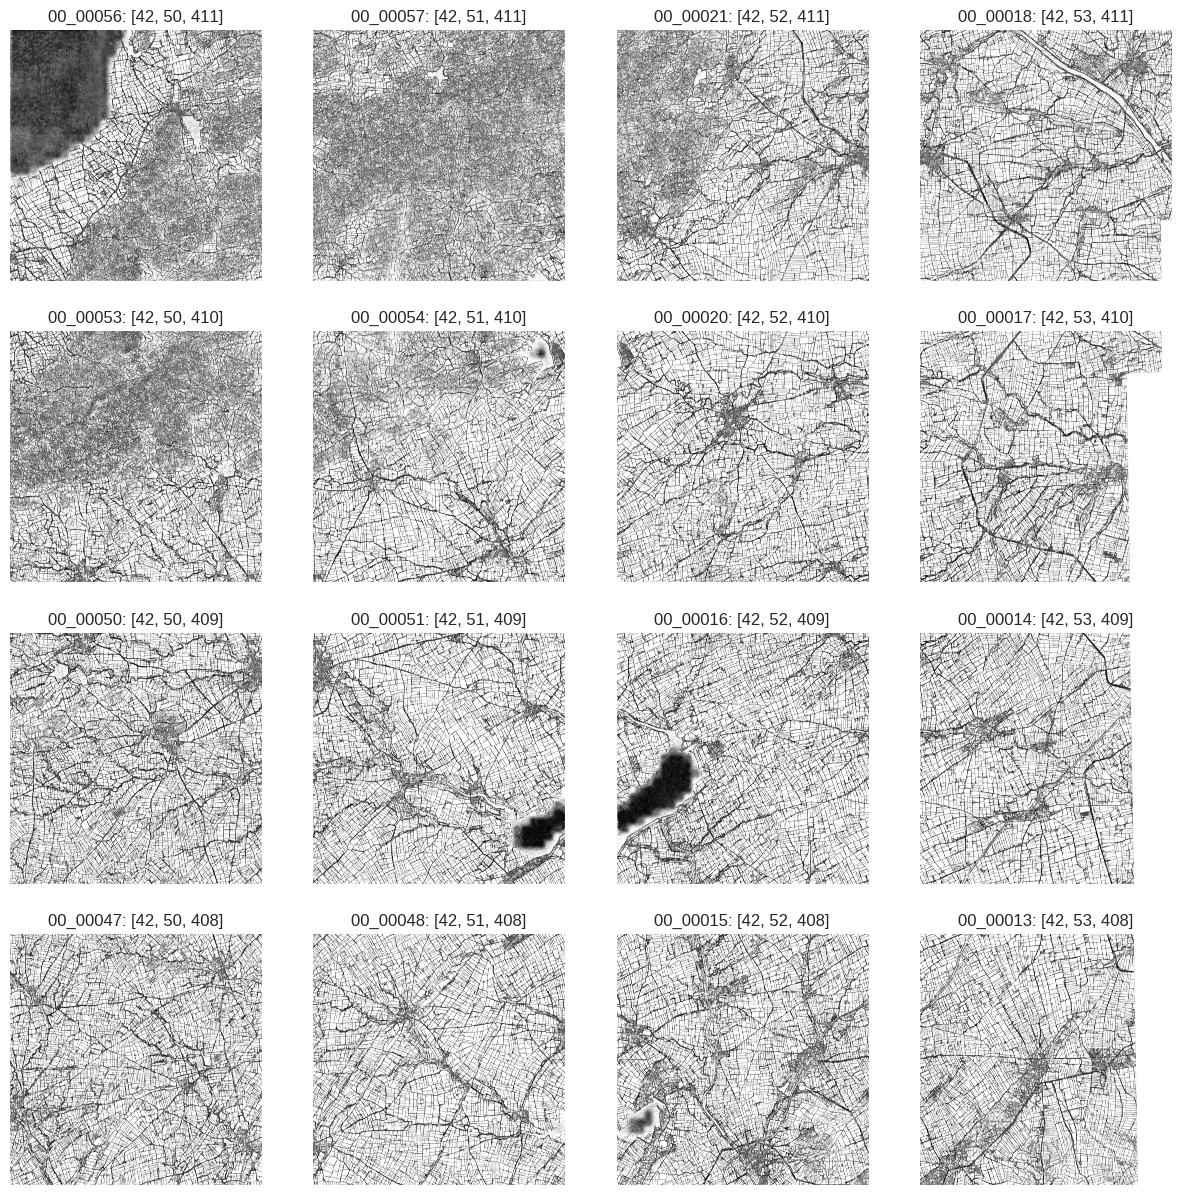

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i, (key, img) in enumerate(boundary_imgs.items()):
    batch, tile_id = key.split("_")
    tile_id = int(tile_id)
    row = meta_df.loc[meta_df["tile_id"] == tile_id].iloc[0]
    c0 = int(row["coord0"])
    c1 = int(row["coord1"])
    c2 = int(row["coord2"])

    x = c1-50
    y = 411-c2

    if x not in range(4) or y not in range(4):
        continue
    ax = axs[y][x]

    coords_str = "{}: [{}, {}, {}]".format(key, c0, c1, c2)
    ax.imshow(img)
    ax.set_title(coords_str)
    ax.axis("off")

### Define function for drawing segmentation results

In [ ]:
def draw_segmentation(img, mapping="random", ax=None):
    if mapping is None:
        draw_img = img
        field_id_mapping = None
    else:
        if mapping == "random":
            field_idxs = np.unique(img)
            np.random.shuffle(field_idxs)
            field_id_mapping = {field_id: i for i,
                            field_id in enumerate(field_idxs)}
        else:
            field_id_mapping = mapping
        draw_img = np.vectorize(field_id_mapping.get)(img)
        draw_img[draw_img == None] = 0
        draw_img = draw_img.astype(np.int64)
        draw_img = np.ma.masked_where(img<2, draw_img)

    cmap = plt.get_cmap('tab20', np.max(draw_img))
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(draw_img, cmap="tab20", interpolation="none")
    return field_id_mapping

## Stitching

### Use only parts of the tiles for testing / demonstration

In [ ]:
AREA_THRESHOLD = 100
OVERLAP = 256

def remove_small_segments_inplace(watershed_img):
    ids, counts = np.unique(watershed_img, return_counts=True)
    watershed_img[np.isin(watershed_img, ids[counts < AREA_THRESHOLD])] = -1

def reindex_segments(watershed_img1, watershed_img2):
    watershed_img1_res = np.zeros_like(watershed_img1)
    watershed_img2_res = np.zeros_like(watershed_img2)

    for i_new, i_old in enumerate(np.unique(watershed_img1)):
        if i_old <= 1:
            continue
        watershed_img1_res[watershed_img1 == i_old] = i_new
    i_new_1_max = i_new

    for i_new, i_old in enumerate(np.unique(watershed_img2)):
        if i_old <= 1:
            continue
        watershed_img2_res[watershed_img2 == i_old] = i_new + i_new_1_max
    return watershed_img1_res, watershed_img2_res

def prepare_segment_ids(watershed_img1, watershed_img2):
    remove_small_segments_inplace(watershed_img1)
    remove_small_segments_inplace(watershed_img2)

    return reindex_segments(watershed_img1, watershed_img2)

In [ ]:
test_tile_size_x = 512*2
test_tile_size_y = 512*2
left_b = boundary_imgs["00_00047"][:test_tile_size_y, -test_tile_size_x:].copy()
right_b = boundary_imgs["00_00048"][:test_tile_size_y, :test_tile_size_x].copy()
left_u = instance_uncertainty_imgs["00_00047"][:test_tile_size_y, -test_tile_size_x:].copy()
right_u = instance_uncertainty_imgs["00_00048"][:test_tile_size_y, :test_tile_size_x].copy()
left = watershed_imgs["00_00047"][:test_tile_size_y, -test_tile_size_x:].copy()
right = watershed_imgs["00_00048"][:test_tile_size_y, :test_tile_size_x].copy()

result = np.zeros((test_tile_size_y, test_tile_size_x*2-OVERLAP), dtype=left.dtype)

### Remove tiny segments and reindex

Segments get new IDs that are unique for both tiles

In [ ]:
left, right = prepare_segment_ids(left, right)

### Draw a line through the buffer strip
Visualize the line

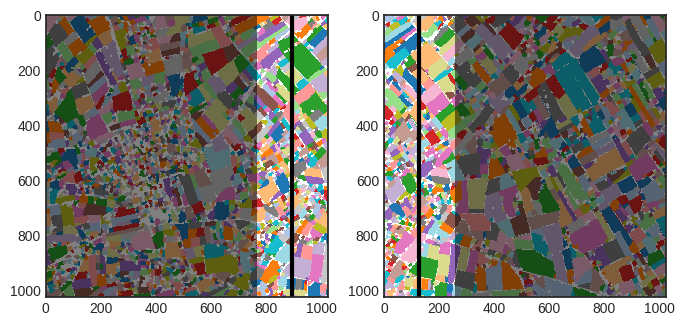

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
draw_segmentation(left, ax=axs[0])
draw_segmentation(right, ax=axs[1])
axs[0].vlines(test_tile_size_x-OVERLAP/2, 0, test_tile_size_y-1, color="black", linewidth=3)
axs[1].vlines(OVERLAP/2, 0, test_tile_size_y-1, color="black", linewidth=3)

rect = matplotlib.patches.Rectangle((0, 0), test_tile_size_x-OVERLAP-1, test_tile_size_y-1, linewidth=0, edgecolor='r', facecolor='black', alpha=0.5)
axs[0].add_patch(rect)
rect = matplotlib.patches.Rectangle((OVERLAP, 0), test_tile_size_x-OVERLAP-1, test_tile_size_y-1, linewidth=0, edgecolor='r', facecolor='black', alpha=0.5)
axs[1].add_patch(rect)


pass

Separate the segments based on whether they are left of the line, right of the line or intersect with the line.

In [ ]:
@nb.njit()
def get_line_separated_ids(img, line_coord):
    segment_ids = np.unique(img)
    segment_ids = segment_ids[segment_ids > 1]  # remove background segment ID if present
    lower, intersection, higher = [], [], []
    for segment_id in segment_ids:
        segment_coords = np.argwhere(img == segment_id)  # for production: use cupy on Cuda GPU to speed up
        if np.max(segment_coords[:, 1]) < line_coord:
            lower.append(segment_id)
        elif np.min(segment_coords[:, 1]) > line_coord:
            higher.append(segment_id)
        else:
            intersection.append(segment_id)
    return lower, intersection, higher

In [ ]:
l_lower, l_intersection, l_higher = get_line_separated_ids(left, test_tile_size_x-OVERLAP/2)
r_lower, r_intersection, r_higher = get_line_separated_ids(right, OVERLAP/2)

Accept all segements left of the line from the left tile and all segments right of the line from the right tile.

In [ ]:
left_mask = np.isin(left, l_lower)
right_mask = np.isin(right, r_higher)

result[:left.shape[0], :left.shape[1]][left_mask] = left[left_mask]
result[-right.shape[0]:, -right.shape[1]:][right_mask] = right[right_mask]

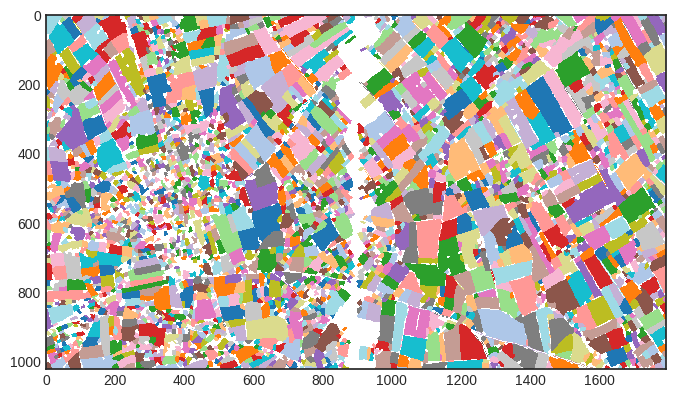

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))
draw_segmentation(result, ax=ax)
pass

Extract the segments, that intersect with the line.

In [ ]:
l_intersection_map = left.copy()
l_intersection_map[~np.isin(l_intersection_map, l_intersection)] = -1
r_intersection_map = right.copy()
r_intersection_map[~np.isin(r_intersection_map, r_intersection)] = -1

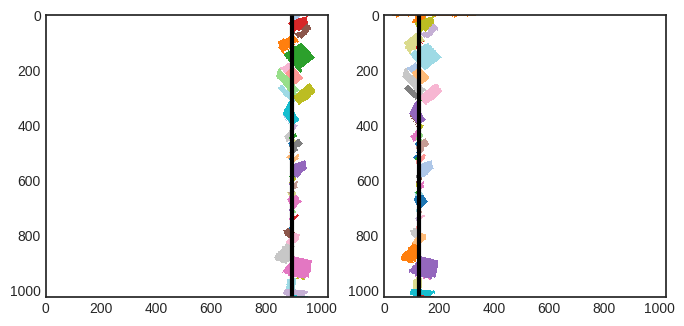

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
draw_segmentation(l_intersection_map, ax=axs[0])
draw_segmentation(r_intersection_map, ax=axs[1])
#axs[0].imshow(left_s)
#axs[1].imshow(right_s)

axs[0].vlines(test_tile_size_x-OVERLAP/2, 0, test_tile_size_y-1, color="black", linewidth=3)
axs[1].vlines(OVERLAP/2, 0, test_tile_size_y-1, color="black", linewidth=3)

pass

## Non maximum suppression

Show uncertainties of the intersecting segments

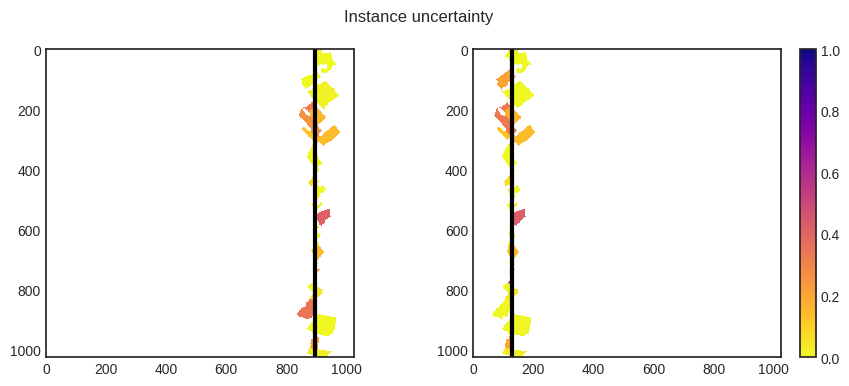

In [ ]:
left_u_masked = np.ma.masked_where(~np.isin(l_intersection_map, l_intersection), left_u)
right_u_masked = np.ma.masked_where(~np.isin(r_intersection_map, r_intersection), right_u)


fig, axs = plt.subplots(1, 2, figsize=(11, 4))
axs[0].imshow(left_u_masked/256, vmin=0, vmax=1, cmap="plasma_r")
map = axs[1].imshow(right_u_masked/256, vmin=0, vmax=1, cmap="plasma_r")
axs[0].vlines(test_tile_size_x-OVERLAP/2, 0, test_tile_size_y-1, color="black", linewidth=3)
axs[1].vlines(OVERLAP/2, 0, test_tile_size_y-1, color="black", linewidth=3)
fig.suptitle("Instance uncertainty")

fig.colorbar(map)

Apply non maximum suppression to decide with of the intersecting segments to accept. Then add the accepted segments to the results image.

In [ ]:
id_base = np.array([4096, 1])

@nb.njit(fastmath=True)
def calc_coord_id(segment_coords):
    return np.sum(segment_coords * id_base, axis=1)

@nb.njit(fastmath=True)
def transform_coords(segment_coords, offset_y=0, offset_x=0):
    segment_coords_t = segment_coords.copy()
    segment_coords_t[:, 0] += offset_y
    segment_coords_t[:, 1] += offset_x
    return segment_coords_t

@nb.njit(fastmath=True)
def find_segments(segmentation, representation, offset_y=0, offset_x=0):
    # Find unique segment IDs
    segment_ids = np.unique(segmentation)
    segment_ids = segment_ids[segment_ids > 1]  # Remove background segment ID if present

    # Initialize a dictionary to store segment representations
    segment_representations = nb.typed.Dict()
    segment_coords_dict = nb.typed.Dict()

    # Iterate over each segment ID

    for segment_id in segment_ids:
        # Find coordinates where segment ID occurs
        segment_coords = np.argwhere(segmentation == segment_id)
        segment_coords_t = transform_coords(segment_coords, offset_y, offset_x)

        segment_representations[segment_id] = representation(segment_coords_t)
        segment_coords_dict[segment_id] = segment_coords

    return segment_representations, segment_coords_dict

@nb.njit(fastmath=True)
def get_iou_and_uncertainty(
        seg1,
        seg2,
        uncertainty_map1,
        uncertainty_map2,
        offset_y=0,
        offset_x=0
    ):
    # Find bounding boxes for segments in both images
    seg1_rep, seg1 = find_segments(seg1, calc_coord_id)
    seg2_rep, seg2 = find_segments(seg2, calc_coord_id, offset_y, offset_x)
    iou = iou_segments(seg1_rep, seg2_rep)
    uncertainty1 = get_uncertainty(seg1, uncertainty_map1)
    uncertainty2 = get_uncertainty(seg2, uncertainty_map2)

    return iou, uncertainty1, uncertainty2

@nb.njit(fastmath=True)
def iou_segments(seg1, seg2):
    # Initialize a matrix to store the IoUs
    iou = np.empty((len(seg1), len(seg2)), dtype=float)

    # Calculate IoU for each pair of segments
    # attention! relying on the order of dicts is only valid in >= Python 3.7
    for i, (seg1_id, seg1_element) in enumerate(seg1.items()):
        for j, (seg2_id, seg2_element) in enumerate(seg2.items()):
            intersection = np.intersect1d(
                seg1_element,
                seg2_element,
            )
            union = np.union1d(
                seg1_element,
                seg2_element,
            )
            iou[i, j] = len(intersection) / len(union)

    return iou

@nb.njit(fastmath=True)
def get_uncertainty(seg, uncertainty_img):
    uncertainty_dict = nb.typed.Dict()

    for i, (seg_id, seg_element) in enumerate(seg.items()):
        pixel = seg_element[0, :] # get arbitrary pixel from segment
        uncertainty_dict[seg_id] = uncertainty_img[pixel[0], pixel[1]]
    return uncertainty_dict

In [ ]:
def get_edge_segments(l_intersection_map, r_intersection_map, left_u, right_u, iou_threshold = 0.5):
    offset_x = l_intersection_map.shape[1] - OVERLAP
    iou, left_uncertainty_dict, right_uncertainty_dict = get_iou_and_uncertainty(l_intersection_map, r_intersection_map, left_u, right_u, 0, offset_x)

    combined_dict = nb.typed.Dict()
    combined_dict.update(left_uncertainty_dict)
    combined_dict.update(right_uncertainty_dict)
    return non_max_suppresion(iou, combined_dict, left_uncertainty_dict, right_uncertainty_dict, iou_threshold)

@nb.njit(fastmath=True)
def non_max_suppresion(iou_matrix, combined_dict, uncertainty_dict1, uncertainty_dict2, iou_threshold):
    sorted_uncertainty_dict = sorted(combined_dict.items(), key=lambda x: x[1])

    left_ids = np.array(list(uncertainty_dict1.keys()))
    right_ids = np.array(list(uncertainty_dict2.keys()))

    left_accept = set()
    right_accept = set()
    discard = set()

    for seg_id, uncertainty in sorted_uncertainty_dict:
        if seg_id in discard:
            continue

        if seg_id in left_ids:
            seg_index = np.where(left_ids == seg_id)[0][0]
            left_accept.add(seg_id)

            discard.update(right_ids[np.argwhere(iou_matrix[seg_index, :] > iou_threshold).flatten()].flatten())
        elif seg_id in right_ids:
            seg_index = np.where(right_ids == seg_id)[0][0]
            right_accept.add(seg_id)

            discard.update(left_ids[np.argwhere(iou_matrix[:, seg_index] > iou_threshold).flatten()].flatten())
    return left_accept, right_accept, discard

def add_edge_segments_inplace(l_intersection_map, r_intersection_map, left_u, right_u, left, right, result):
    left_accept, right_accept, discard = get_edge_segments(l_intersection_map, r_intersection_map, left_u, right_u)

    left_mask = np.isin(left, list(left_accept))
    right_mask = np.isin(right, list(right_accept))

    result[:left.shape[0], :left.shape[1]][left_mask] = left[left_mask]
    result[-right.shape[0]:, -right.shape[1]:][right_mask] = right[right_mask]

In [ ]:
add_edge_segments_inplace(l_intersection_map, r_intersection_map, left_u, right_u, left, right, result)

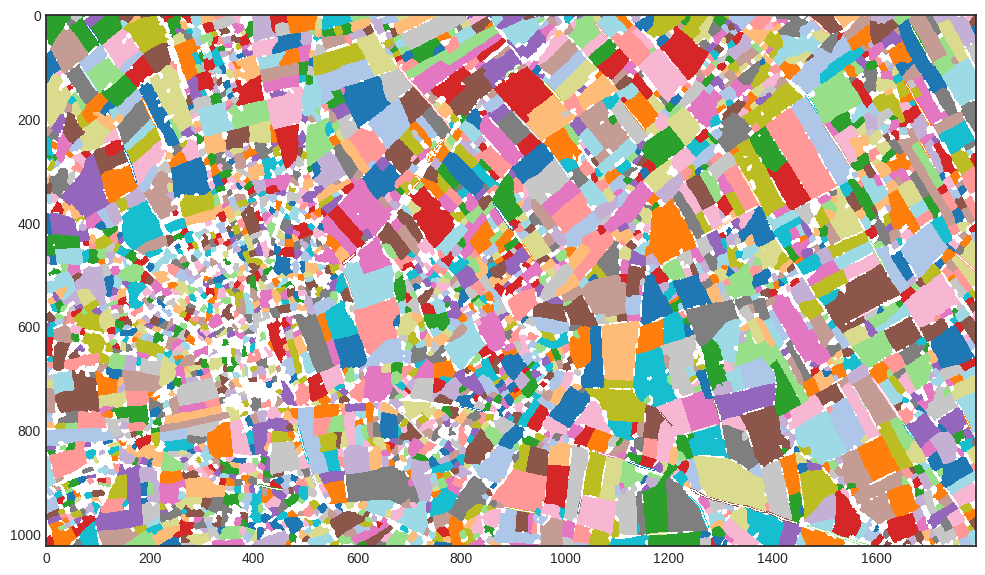

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8))
draw_segmentation(result, ax=ax)
pass

Visualize IoU

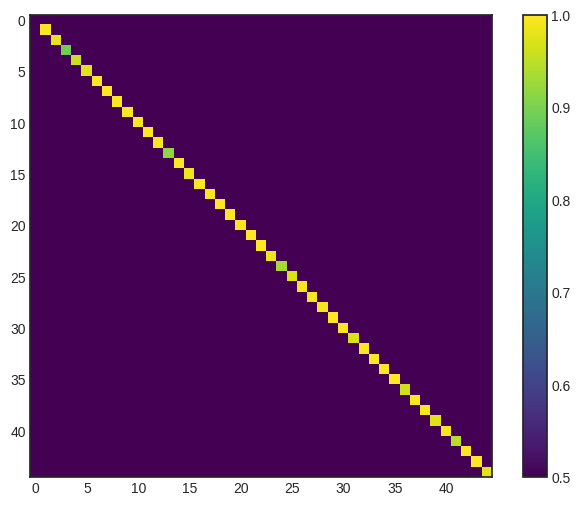

In [ ]:
iou = get_iou_and_uncertainty(l_intersection_map, r_intersection_map, left_u, right_u, 0, l_intersection_map.shape[1] - OVERLAP)[0]
fig, ax = plt.subplots(figsize=(8,6))
a = ax.imshow(iou, cmap="viridis", vmin=0.5)
fig.colorbar(a)